<a href="https://colab.research.google.com/github/tlohde/sense_GEE/blob/main/SENSE_2020_GEE/3_Classification__forProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import earthengine API
import ee
# Authenticate and initialise 
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=YZqkn9J2L1e3TJGGxOogSoWl_lzq4OmGjoyYBRBITcQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWg5mBvKezRrViXDSSK_uDGRVuW8l7LQ84TfUu3DsdqrxAUfep5lOvw

Successfully saved authorization token.


In [42]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

#!pip install geehydro # Life saver for plotting GEE stuff with Python!
import geehydro
import folium

import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

import geemap


Installing geemap ...


Number of images in collection:  9

ee.Feature({
  "functionInvocationValue": {
    "functionName": "Image.sampleRectangle",
    "arguments": {
      "image": {
        "functionInvocationValue": {
          "functionName": "Image.select",
          "arguments": {
            "bandSelectors": {
              "constantValue": [
                "B4",
                "B3",
                "B2"
              ]
            },
            "input": {
              "functionInvocationValue": {
                "functionName": "Collection.first",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "Collection.filter",
                      "arguments": {
                        "collection": {
                          "functionInvocationValue": {
                            "functionName": "Collection.filter",
                            "arguments": {
                              "collection": 

(array([ 1398.,  6317.,  4279.,  3880.,  8743., 22796., 72945., 72094.,
        12076.,   258.]),
 array([7357. , 7477.7, 7598.4, 7719.1, 7839.8, 7960.5, 8081.2, 8201.9,
        8322.6, 8443.3, 8564. ]),
 <a list of 10 Patch objects>)

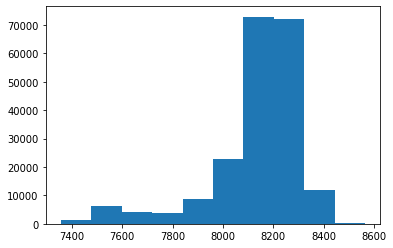

In [115]:
lon = -4.248941
lat = 49.852876

# collection of landsat8 images between dates at point of interest
l8_col = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterBounds(ee.Geometry.Point(lon, lat)).filterDate('2020-05-01','2020-07-31')

# Get the number of images.
count = l8_col.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get the date range of images in the collection.

# range = collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
# print('Date range: ', str(ee.Date(range.get('min')).getInfo()), str(ee.Date(range.get('max')).getInfo())+'\n')

##### get dates of each image

dates = l8_col.getArray("system:time_start")

point = ee.Geometry.Point(-4.248941, 49.852876)

# Get info from the point

info = l8_col.getRegion(point,30).getInfo() # change colelction by series
# print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = pd.array([datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))])
#print(time)
# june23 = l8_col.filterDate('2020-06-23').first()
june23 = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterBounds(ee.Geometry.Point(lon, lat)).filterDate('2020-06-21','2020-06-25').first()

june23_rgb = june23.select(['B4','B3','B2'])

# Image(url=june23.getThumbUrl({'min': 0, 'max': 30000, 'bands':['B4','B3','B2'],'dimensions': 512}))

aoi = ee.Geometry.Polygon(
    [[-4.4250233, 50.097365],
      [-4.4332587,50.0885514],
      [-4.4250233,49.9985597],
      [-4.2136499,50.005624],
      [-4.1999243,50.0956024],
      [-4.4250233,50.097365]])

# sample the specific band from image, and convert to 2d array
band_arrs = june23_rgb.sampleRectangle(region = aoi)
print(band_arrs)
b4 = band_arrs.get('B4')
nparr_b4 = np.array(b4.getInfo())
print(b4)
# flatten to 1d and get histogram of band
plt.hist(nparr_b4.flatten())


## Unsupervised classification

The `ee.Clusterer` package handles unsupervised classification (or clustering) in Earth Engine. More details about each Clusterer are available in the [reference docs in the Code Editor](https://code.earthengine.google.com/#workspace).

Clusterers are used in the same manner as classifiers in Earth Engine. The general workflow for clustering is:

*  Assemble features with numeric properties in which to find clusters.
*   Instantiate a clusterer. Set its parameters if necessary.
*  Train the clusterer using the training data.
* Apply the clusterer to an image or feature collection.
* Label the clusters.


The training data is a `FeatureCollection` with properties that will be input to the clusterer. 

Unlike classifiers, there is no input class value for a Clusterer. 

Like classifiers, the data for the train and apply steps are expected to have the same number of values. When a trained clusterer is applied to an image or table, it assigns an integer cluster ID to each pixel or feature.

These algorithms are currently based on the algorithms with the same name in [Weka](https://www.cs.waikato.ac.nz/ml/weka/).

Here is a simple example of building and using an `ee.Clusterer`:

In [ ]:
##### create land mask ####

# ndwi 
ndwi = june23.normalizedDifference(['B3', 'B5']) # green and NIR

# Create binary image - water vs. not water
water = ndwi.gt(0) # from McFeeters (1996)

# mask landsat image
june23_masked = june23.updateMask(water)

#### create map
maskMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)
# add layers
maskMap.addLayer(water,{'min':0, 'max':1},'water')
maskMap.addLayer(june23_masked, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'masked landsat image')
# add layer control and view map
folium.LayerControl().add_to(maskMap)
maskMap

In [112]:

# # Define a region in which to generate a sample of the input.

# lowerleft = ee.Geometry.Point(-5.537,48.50)
# upperright = ee.Geometry.Point(-1.11,51.719)
# region = ee.Geometry.Rectangle([lowerleft, upperright])

# not necessary to define region - as if unpecified defaults to whole image footprint

# Make the training dataset.
training = june23_masked.sample(scale= 30,  numPixels= 5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(3).train(training)

# Cluster the input using the trained clusterer.
result = june23_masked.cluster(clusterer)

# Display the clusters with random colors.

resultsMap = folium.Map(location = [50.00,-4.2,],zoom_start=9)
resultsMap.addLayer(result.randomVisualizer(), {}, 'clusters')
resultsMap.addLayer(june23, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'landsat image')
folium.LayerControl().add_to(resultsMap)
resultsMap
